In [4]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [3]:
LFR = np.load("./Dataset/LFR.npy")
H_k = np.load("./Dataset/H_k.npy")

In [6]:
H_k_func = interp1d(LFR, H_k.T)

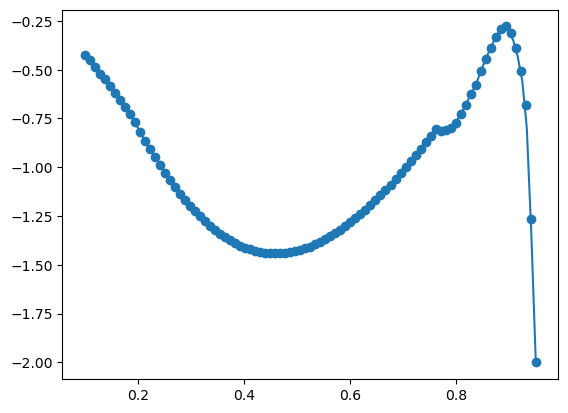

In [10]:
lfr = np.linspace(LFR.min(), LFR.max(), 101)
plt.plot(lfr, H_k_func(lfr)[0, :])
plt.scatter(LFR, H_k[:, 0])

In [11]:
H_k_func(0.2)

array([-0.79823419,  1.77423108,  1.78161824,  1.53014621,  1.29678932,
        1.38588489,  3.29609721,  3.67148589, -0.40166724, -1.85625969])

In [12]:
from EqMotion import Integrator

integrator = Integrator()

In [13]:
def LFR(t):
    return 0.95 - (0.95-0.15) / 150.0 * t

def alpha3(t):
    return 9.8 + (60.0 - 9.8) * t / 150.0

def alpha2(t):
    return np.sin(t * 2 * np.pi / 3.0) * np.tanh(t/150.0)

def theta(t):
    return 0.0

def d2theta(t):
    return 0.0

In [17]:
t = np.linspace(0.0, 150.0, 1501)
y0 = np.zeros(6)

sol = integrator.solve(y0, t, args=(alpha2, alpha3, theta, d2theta, LFR))

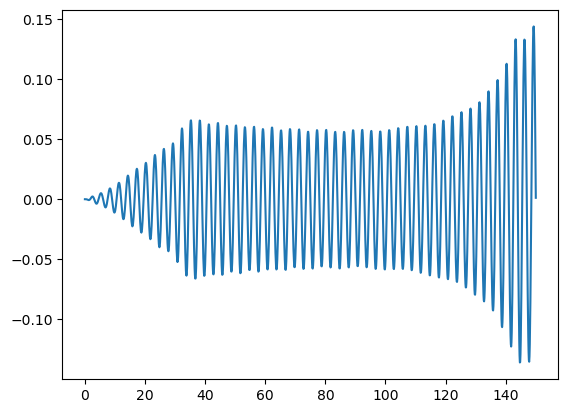

In [20]:
plt.plot(t, sol[:, 0])